# Importing the needed libraries

In [24]:
import os
import sys
import time
import argparse
import requests
import contextlib
from tqdm import tqdm
import tempfile
import h5py
import atexit
import numpy as np
#from illustris_python.groupcat import loadSingle, loadHeader
#import illustris_python as il
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mpl3
from numpy.linalg import eig
from numpy.linalg import eigh
from scipy.optimize import curve_fit, root
from scipy.spatial.transform import Rotation as R
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec


G     = 4.3e-6 # Grav. constant [kPc/M_{sun} (km/s)^2]
H0    = 67.74 # Hubble Constant [km/s / Mpc]
h     = H0 / 100 
rho_c = 3*(H0**2)/(8*np.pi*G*1e-3) # Critical density [M_{sun}/Mpc**3]
rho_c = rho_c * (1e-3 ** 3) #2.7754 * 1e2 * (H0/100)**2 # Critical density [M_{sun}/Kpc**3]
Nfields = 9
M_dm    = 7.5e6 # M_sun
headers = {"api-key": '81b7c70637fa8b110e6b9f236ea07c37'}
box_size = 75 * 1e3 / h # kpc

R_bins = np.geomspace(1, 100, 20)

# Some custom functions

In [2]:
def get(path, params=None, folderName=''):
    '''
    Illustris function
    '''
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        if filename.endswith('.hdf5'):
            file_access_property_list = h5py.h5p.create(h5py.h5p.FILE_ACCESS)
            file_access_property_list.set_fapl_core(backing_store=False)
            file_access_property_list.set_file_image(r.content)
            
            file_id_args = {
                'fapl': file_access_property_list,
                'flags': h5py.h5f.ACC_RDONLY,
                'name': next(tempfile._get_candidate_names()).encode()
            }
            
            h5_file_args = {'backing_store': False, 'driver': 'core', 'mode': 'r'}
            with contextlib.closing(h5py.h5f.open(**file_id_args)) as file_id:
                with h5py.File(file_id, **h5_file_args) as h5_file:
                    #return np.array(h5_file['grid'])
                    if 'grid' in h5_file.keys(): return np.array(h5_file['grid'])
                    else:
                        results = []
                        for k in h5_file.keys():
                            for sk in h5_file[k].keys():
                                results.append(np.array(h5_file[k][sk]))
                        return results
        else:
            with open(folderName + filename, 'wb') as f:
                f.write(r.content)
            return filename # return the filename string
    return r


In [3]:
def get1(path, name, params=None):
    '''
    Illustris function
    '''
    # make HTTP GET request to path
    headers = {"api-key":"81b7c70637fa8b110e6b9f236ea07c37"}
    r = requests.get(path, params=params, headers=headers)
    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(name + '.hdf5', 'wb') as f:
            f.write(r.content)
        return name + '.hdf5' # return the filename string
    return NULL

In [4]:
def compute_mass_profile(gid, center):
    '''
    MIHAEL FUNCTION: compute the dark matter mass enclosed in 20 radii
    from 1 to 100 kPc
    
    Parameters
    ----------
    gid : int 
        GroupID
    center : list
        (x,y,z) Position of the group
    
    Returns
    -------
    
    NP Array
        Array with the dark matter mass enclosed in 20 radii from 1 to 100 kPc
    '''
    dm = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'dm', fields=['Coordinates'])
    dm = np.where(dm > 32500, dm - 75000, dm)
    dm = np.where(dm < -32500, dm + 75000, dm)
    center = np.where(center > 32500, center - 75000, center)
    center = np.where(center < -32500, center + 75000, center)
    dm = dm - center
    dist = []
    for d in dm:
        D = np.sqrt(sum([c**2 for c in d]))
        if D < 100: dist.append(D)
    R_bins = np.geomspace(1, 100, 20)
    M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
    return M

In [5]:
def compute_total_mass_profile(Rmax, Rmin, Nm, sub_meta, url):
    '''
    Computes the dark matter, stars and gas mass enclosed in Nm radii
    from Rmin to Rmax kPc
    
    Parameters
    ----------
    Rmin, Rmax : float 
        Min and Max radii
    Nm : int
        Number of radial bins
    sub_meta : str
        Illustris information of the subhalo
    url : str
        Url to the Illustris server
    
    Returns
    -------
    
    List
        List of 4 Arrays corresponding to the radial bins and the 
        dark matter, stars and gas mass enclosed in Nm radii from 
        Rmin to Rmax kPc
    '''
    center = np.array([sub_meta['pos_x'], sub_meta['pos_y'], sub_meta['pos_z']])
    particles  = get(url + 'cutout.hdf5', {'dm':'Coordinates',
                                                'gas':'Coordinates,Masses',
                                                'stars':'Coordinates,Masses'
                                               })
    
    dm = particles[2] - center
    dm = np.where(dm > 32500, dm - 75000, dm)
    dm = np.where(dm < -32500, dm + 75000, dm)
    
    dist_dm = []
    for d in dm:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_dm.append(D)
    
    m_gas = particles[1] * 1e10/h
    gas = particles[0] - center
    gas = np.where(gas > 32500, gas - 75000, gas)
    gas = np.where(gas < -32500, gas + 75000, gas)
    
    dist_gas = []
    for d in gas:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_gas.append(D)

    m_stars = particles[4] * 1e10/h
    stars = particles[3] - center
    stars = np.where(stars > 32500, stars - 75000, stars)
    stars = np.where(stars < -32500, stars + 75000, stars)
    
    dist_stars = []
    for d in stars:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_stars.append(D)
            
    R_bins = np.geomspace(Rmin, Rmax, Nm)
    
    p_dm    = np.array([len(np.where(np.array(dist_dm) < R)[0]) * M_dm for R in R_bins])
    p_stars = np.array([sum(m_stars[np.where(np.array(dist_stars) < R)[0]]) for R in R_bins])
    p_gas   = np.array([sum(m_gas[np.where(np.array(dist_gas) < R)[0]]) for R in R_bins])
    return R_bins, p_dm, p_stars, p_gas

In [6]:
def compute_rot_mat_inertia(subhalo_pos, coordinates, masses, Rmin=0, Rmax=20):
    '''
    MIHAEL FUNCTION: computes the intertia momenta of a subhalo with ID sid
    
    Parameters
    ----------
    
    
    Returns
    -------
    
    Matrix
        Rotation matrix for align the intertia momenta with the z-axis
    '''
    
    coordinates = coordinates - subhalo_pos # Let's center the particles
    dist = np.linalg.norm(coordinates, axis=1)
    indices1 = np.argwhere(dist < Rmin)
    indices2 = np.argwhere(dist > Rmax)
    indices = np.concatenate((indices1, indices2))
    distances = np.delete(dist, indices)
    coordinates = np.delete(coordinates, indices, axis=0)
    masses = np.delete(masses, indices)
    
    I = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if i == j: I[i][j] = np.sum(masses * (distances**2 - coordinates[:,i] * coordinates[:,j]))
            else: I[i][j] = np.sum(masses * (- coordinates[:,i] * coordinates[:,j]))
    
    I_eign = np.linalg.eigh(I)
    L = I_eign[1][2]
    #print(I)
    #print(L / np.linalg.norm(L))
    
    rot, _ = R.align_vectors([L, np.cross(L, [1,0,0])], [[0,0,1],[0,1,0]])
    return rot.as_matrix(), L



In [7]:
def compute_rot_mat_angMom(subhalo_pos, coordinates, velocities, masses, Rmin = 0, Rmax = 20):
    
    coordinates = coordinates - subhalo_pos # Let's center the particles
    
    dist = np.linalg.norm(coordinates, axis=1)
    indices1 = np.argwhere(dist < Rmin)
    indices2 = np.argwhere(dist > Rmax)
    indices = np.concatenate((indices1, indices2))
    distances = np.delete(dist, indices)
    
    coordinates = np.delete(coordinates, indices, axis = 0)
    masses = np.delete(masses, indices)
    velocities = np.delete(velocities, indices, axis = 0)
    
    L = (np.cross(coordinates, velocities).T * np.array(masses)).T
    Lmean = np.mean(L, axis=0)
    #print(Lmean / np.linalg.norm(Lmean))
    
    rot, _ = R.align_vectors([Lmean, np.cross(Lmean, [1,0,0])], [[0,0,1],[1,0,0]])
    return rot.as_matrix(), Lmean

In [8]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

# Looking for the subhalos

In [ ]:
N     = 40000 # Number of samples.

Mmin  = 1e10 # Minimum total mass.
Mmax  = 1e13 # Maximum total mass.
Mdmin = 1e9 # Minimum dark matter mass in half radius.
Mdmax = 1e13 # Maximum dark matter mass in half radius.
Mgmin = 1e8 # Minimum gas mass.
Mgmax = 1e13 # Maximum gas mass.
Msmin = 1e10 # Minimum stellar mass.
Msmax = 1e12 # Maximum stellar mass.

sim   = 'TNG100-1' # Name of simulation run.
z     = 99  # Snapshot number.
myBasePath = '../sims.TNG/' + sim +'/output/'

mass_min      = (Mmin / h) * 1e-10 # Minimum total mass
mass_max      = (Mmax / h) * 1e-10 # Maximum total mass
dm_mass_min   = (Mdmin / h) * 1e-10 # Minimum total dm mass
dm_mass_max   = (Mdmax / h) * 1e-10 # Maximum total dm mass
gas_mass_min  = (Mgmin / h) * 1e-10 # Minimum total gas mass
gas_mass_max  = (Mgmax / h) * 1e-10 # Maximum total gas mass
star_mass_min = (Msmin / h) * 1e-10 # Minimum total star mass
star_mass_max = (Msmax / h) * 1e-10 # Maximum total star mass


subhalos_url = 'http://www.tng-project.org/api/' + sim + '/snapshots/' + str(z) + '/subhalos'
url          = subhalos_url
subhalos     = get(subhalos_url, {'limit': N, 'offset': 0,
                                #'mass__gt': mass_min, 'mass__lt': mass_max,                                     
                                #'massinhalfrad_dm__gt':dm_mass_min,'massinhalfrad_dm__lt':dm_mass_max, 
                                #'mass_gas__gt': gas_mass_min, #'mass_gas__lt': gas_mass_max,
                                'mass_stars__gt': star_mass_min, 'mass_stars__lt': star_mass_max,
                                'filterFlag': True, 'parent__lt':1, 
                                'sfr__gt':0.1,
                                'subhaloflag__gt':0})

nsubhalos = len(subhalos['results'])

In [ ]:
nsubhalos

# Analyzing each individual subhalo (ie galaxy)

In [11]:
!pwd

/u/m/mdelosri/MaDaMe/codes


In [20]:
file = '../data/gals_properties.h5'
data = h5py.File(file, 'a')

BlockingIOError: [Errno 11] Unable to synchronously open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [ ]:
list(data.keys())

In [ ]:
try:
    flag_MainProps = True
    old_MainProps = data['MainProps'][()]
except:
    flag_MainProps = False

In [16]:
#itialization of properties 
save_part_halo = True
save_part_subhalo = True

nsubhalos = 6
properties = np.zeros((nsubhalos, 17))

# 0: ID
# 1: central (1 if central, 0 if not)
# 2: SubMass [Msun]
# 3: SubSFR
# 4: SubHMR [kPc]
# 5: x [kPc]
# 6: y [kPc]
# 7: z [kPc]
# 8: vx [km/s]
# 9: vy [km/s]
# 10: vz [km/s]
# 11: SubVmax [km/s]
# 12: SubVmaxR [kPc]
# 13: SubHMRG [kPc] Comoving radius containing half of the mass of this Subhalo 
                    # split by Type (SubhaloMassType). Type 4 = gas
# 14: costheta. Cosine of the angle between the angular momenta and the main axis
                # of the inertia tensor.
# 15: kappa_AM
# 16: kappa_IT

#i = 2
for i in tqdm(range(3,nsubhalos)):
    print(data.keys())
    ids = subhalos['results'][i]['id']
    if 'SubID_' + str(ids) in data.keys():
        flag_gr = False # This means that we do not have to analyze the group
        print('Subhalo ' + str(ids) + ' already exists')
        if not data['SubID_' + str(ids)].attrs['done']:
            print('The analysis of the subhalo was not finished OK, so we have to do it again :(')
            flag_gr = True # This means that we have to analyze the group
            del data['SubID_' + str(ids)]
            gr = data.create_group('SubID_' + str(ids))
    else:
        gr = data.create_group('SubID_' + str(ids))
        flag_gr = True # This means that we have to analyze the group
        gr.attrs['done'] = False
        
    #try:
    #    gr = data.create_group('SubID_' + str(ids))
    #    flag_gr = True
    #    gr.attrs['done'] = False
    #except:
    #    flag_gr = False
    #    print('Subhalo ' + str(ids) + ' already exists')
    #    del data['SubID_' + str(ids)]
    #    gr = data.create_group('SubID_' + str(ids))
    #    if not gr.attrs['done']: flag_gr = True # This means that we have to analyze the group

    if flag_gr:
        # Let's load the data of the subhalos
        #sub_meta = il.groupcat.loadSingle('/home/tnguser/sims.TNG/TNG100-1/output/', 99, subhaloID = ids)
        sub_meta = get(subhalos['results'][i]['url'])
        
        # --------------------------------------------------------

        # Let's save the main properties  ------------------------           
        properties[i, 0] = ids   
        gid = sub_meta['grnr'] # sub_meta['SubhaloGrNr']
        properties[i, 1] = gid
        properties[i, 2] = sub_meta['mass'] * 1e10 / h # [Msun] #sub_meta['SubhaloMass'] * 1e10 / h
        properties[i, 3] = sub_meta['sfr'] # [Msun/yr] # sub_meta['SubhaloSFR']
        properties[i, 4] = sub_meta['halfmassrad'] / h # [kPc]  # sub_meta['SubhaloHalfmassRad'] / h
        properties[i, 5] = sub_meta['pos_x'] / h # [kPc]  # sub_meta['SubhaloPos'][0] / h
        properties[i, 6] = sub_meta['pos_y'] / h # [kPc]  # sub_meta['SubhaloPos'][1] / h
        properties[i, 7] = sub_meta['pos_z'] / h # [kPc]  # sub_meta['SubhaloPos'][2] / h
        properties[i, 8] = sub_meta['vel_x'] # [km/s] # sub_meta['SubhaloVel'][0]
        properties[i, 9] = sub_meta['vel_y'] # [km/s] # sub_meta['SubhaloVel'][1]
        properties[i, 10] = sub_meta['vel_z'] # [km/s] # sub_meta['SubhaloVel'][2]
        properties[i, 11] = sub_meta['vmax'] # [km/s] # sub_meta['SubhaloVmax']
        properties[i, 12] = sub_meta['vmaxrad'] / h # [kPc] # sub_meta['SubhaloVmaxRad'] / h
        properties[i, 13] = sub_meta['halfmassrad_stars'] / h # [kPc] # sub_meta['SubhaloHalfmassRadType'][4] / h


        gr.create_dataset('Props', data = properties[i,:])
        #gr.attrs['mass'] = sub_meta['mass'] * 1e10 / h # [Msun] #sub_meta['SubhaloMass'] * 1e10 / h
        #gr.attrs['sfr'] = sub_meta['sfr'] # [Msun/yr] # sub_meta['SubhaloSFR']
        #gr.attrs['halfmassrad'] = sub_meta['halfmassrad'] / h # [kPc]  # sub_meta['SubhaloHalfmassRad'] / h
        #gr.attrs['pos_x'] = sub_meta['pos_x'] / h # [kPc]  # sub_meta['SubhaloPos'][0] / h
        #gr.attrs['pos_y'] = sub_meta['pos_y'] / h # [km/s] # sub_meta['SubhaloVel'][0]
        #gr.attrs['pos_z'] = sub_meta['pos_z'] / h
        #gr.attrs['vel_x'] = sub_meta['vel_x']
        #gr.attrs['vel_y'] = sub_meta['vel_y']
        #gr.attrs['vel_z'] = sub_meta['vel_z']
        #gr.attrs['vmax'] = sub_meta['vmax'] # [km/s] # sub_meta['SubhaloVmax']
        #gr.attrs['vmaxrad'] = sub_meta['vmaxrad'] / h # [kPc] # sub_meta['SubhaloVmaxRad'] / h
        #gr.attrs['halfmassrad_stars'] = sub_meta['halfmassrad_stars'] / h # [kPc] # sub_meta['SubhaloHalfmassRadType'][4] / h
        # --------------------------------------------------------

        # Let's estimate properties with the particles of the subhalos
        print('Starting the estimation of properties with subhalo particles for galaxy ' + str(ids))
        #try:
        #sub_meta     = get(subhalos['results'][i]['url'])
        sub_data_url = subhalos['results'][i]['url'] + 'vis.hdf5'
        center_sub   = properties[i, 5:8]
        velocity     = properties[i, 8:11]

        
        stars_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                           {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
        stars_c = stars_subhalo[0] / h
        stars_v = stars_subhalo[6]
        stars_m = stars_subhalo[4] * 1e10 / h
        try:
            gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                   {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})

            #gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
            #                   {'gas':'coordinates,density,GFM_Metallicity,masses,SubfindHsml,velocities'})
            gas_c   = gas_subhalo[0] / h
            gas_v   = gas_subhalo[8]
            gas_m   = gas_subhalo[6] * 1e10 / h
            gas_HI  = gas_subhalo[4][:,0]
            flag_gas = True
        except:
            print('Galaxy ' + str(ids) + ' have no gas')
            flag_gas = False
        dm_c    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Coordinates'})[0] / h
        dm_v    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Velocities'})[0]

        # Let's move the coordinates if they are near the border
        aux_ind = np.where( (stars_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
        stars_c[aux_ind, 0] = stars_c[aux_ind, 0] - box_size
        aux_ind = np.where( (center_sub[0] - stars_c[:, 0]) > (box_size / 2) )[0]
        stars_c[aux_ind, 0] = stars_c[aux_ind, 0] + box_size
        aux_ind = np.where( (stars_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
        stars_c[aux_ind, 1] = stars_c[aux_ind, 1] - box_size
        aux_ind = np.where( (center_sub[1] - stars_c[:, 1]) > (box_size / 2) )[0]
        stars_c[aux_ind, 1] = stars_c[aux_ind, 1] + box_size
        aux_ind = np.where( (stars_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
        stars_c[aux_ind, 2] = stars_c[aux_ind, 2] - box_size
        aux_ind = np.where( (center_sub[2] - stars_c[:, 2]) > (box_size / 2) )[0]
        stars_c[aux_ind, 2] = stars_c[aux_ind, 2] + box_size
        
        if flag_gas:
            aux_ind = np.where( (gas_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            gas_c[aux_ind, 0] = gas_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - gas_c[:, 0]) > (box_size / 2) )[0]
            gas_c[aux_ind, 0] = gas_c[aux_ind, 0] + box_size
            aux_ind = np.where( (gas_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            gas_c[aux_ind, 1] = gas_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - gas_c[:, 1]) > (box_size / 2) )[0]
            gas_c[aux_ind, 1] = gas_c[aux_ind, 1] + box_size
            aux_ind = np.where( (gas_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            gas_c[aux_ind, 2] = gas_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - gas_c[:, 2]) > (box_size / 2) )[0]
            gas_c[aux_ind, 2] = gas_c[aux_ind, 2] + box_size
            
        aux_ind = np.where( (dm_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
        dm_c[aux_ind, 0] = dm_c[aux_ind, 0] - box_size
        aux_ind = np.where( (center_sub[0] - dm_c[:, 0]) > (box_size / 2) )[0]
        dm_c[aux_ind, 0] = dm_c[aux_ind, 0] + box_size
        aux_ind = np.where( (dm_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
        dm_c[aux_ind, 1] = dm_c[aux_ind, 1] - box_size
        aux_ind = np.where( (center_sub[1] - dm_c[:, 1]) > (box_size / 2) )[0]
        dm_c[aux_ind, 1] = dm_c[aux_ind, 1] + box_size
        aux_ind = np.where( (dm_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
        dm_c[aux_ind, 2] = dm_c[aux_ind, 2] - box_size
        aux_ind = np.where( (center_sub[2] - dm_c[:, 2]) > (box_size / 2) )[0]
        dm_c[aux_ind, 2] = dm_c[aux_ind, 2] + box_size
        # --------------------------------------------------------
        
        # ------------------Let's center the particles -----------
        stars_c = stars_c - center_sub
        stars_v = stars_v - velocity
        
        dm_v = dm_v - velocity
        dm_c = dm_c - center_sub
        
        if flag_gas:
            gas_c = gas_c - center_sub
            gas_v = gas_v - velocity
        # --------------------------------------------------------
              
        # Let's Compute the distance of each DM particle to the center and sum in radial bins
        dist = np.linalg.norm(dm_c, axis=1)
        #for d in dm_c:
        #    D = np.sqrt(sum([c**2 for c in d]))
        #    if D < 100: dist.append(D)
        M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
        ind_dm = np.where(np.array(dist) < (3 * properties[i, 4]))[0] # for saving only close particles
        # --------------------------------------------------------

        # Let's Compute the distance of each star particle to the center and sum in radial bins
        dist = np.linalg.norm(stars_c, axis=1)
        #for d in stars_c:
        #    D = np.sqrt(sum([c**2 for c in d]))
        #    if D < 100: dist.append(D)
        M_stars = np.array([np.sum( stars_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
        ind_stars = np.where(np.array(dist) < (3 * properties[i, 4]))[0] # for saving only close particles
        # --------------------------------------------------------

        # Compute the distance of each particle to the center and sum in radial bins
        if flag_gas:
            dist = np.linalg.norm(gas_c, axis=1)
            #for d in gas_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M_gas = np.array([np.sum( gas_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_gas = np.where(np.array(dist) < (3 * properties[i, 4]))[0] # for saving only close particles
        # --------------------------------------------------------

        # Let's save the particles
        if save_part_subhalo:
            np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsCoord.txt', stars_c[ind_stars])
            #np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsCoord.txt', aux_subhalo[0])
            np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsInitMass.txt', stars_subhalo[1][ind_stars])
            np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsMetal.txt', stars_subhalo[2][ind_stars])
            np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsSFT.txt', stars_subhalo[3][ind_stars])
            np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsMasses.txt', stars_m[ind_stars])
            np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsHsml.txt', stars_subhalo[5][ind_stars])
            np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsVels.txt', stars_v[ind_stars])
            if flag_gas:
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasCoord.txt', gas_c[ind_gas])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasDens.txt', gas_subhalo[1][ind_gas])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_eAbund.txt', gas_subhalo[2][ind_gas])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasMetal.txt', gas_subhalo[3][ind_gas])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasHI.txt', gas_HI[ind_gas])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_intEne.txt', gas_subhalo[5][ind_gas])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasMasses.txt', gas_m[ind_gas])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasHsml.txt', gas_subhalo[7][ind_gas])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasVels.txt', gas_v[ind_gas])
        # ----------------------------------------------
        
        # Let's save the data of these profiles
        gr.create_dataset('R_bins_sub', data = R_bins)
        gr.create_dataset('M_DM_sub', data = M)
        gr.create_dataset('M_stars_sub', data = M_stars)   
        if flag_gas:
            gr.create_dataset('M_gas_sub', data = M_gas)
        # --------------------------------------------------------

        # Let's compute the rotation matrix taking into accunt the inertia tensor
        rot_mat_IT, L_IT = compute_rot_mat_inertia(np.zeros(3), stars_c, stars_m, Rmax = 2 * properties[i, 13])
        # --------------------------------------------------------

        # Let's compute the rotation matrix taking into accunt the angular momentum tensor
        rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_c, stars_v, stars_m, Rmax = 2 * properties[i, 13])
        # --------------------------------------------------------

        # Let's rotate the coordiantes with AM
        dm_c_rot_AM = dm_c @ rot_mat_AM
        dm_v_rot_AM = dm_v @ rot_mat_AM
        stars_c_rot_AM = stars_c @ rot_mat_AM
        stars_v_rot_AM = stars_v @ rot_mat_AM
        if flag_gas:
            gas_c_rot_AM = gas_c @ rot_mat_AM
            gas_v_rot_AM = gas_v @ rot_mat_AM

        L_AM_rot_AM = L_AM @ rot_mat_AM
        L_IT_rot_AM = L_IT @ rot_mat_AM
        # --------------------------------------------------------

        # Let's rotate the coordiantes with IT
        dm_c_rot_IT = dm_c @ rot_mat_IT
        dm_v_rotv = dm_v @ rot_mat_IT
        stars_c_rot_IT = stars_c @ rot_mat_IT
        stars_v_rot_IT = stars_v @ rot_mat_IT
        if flag_gas:
            gas_c_rot_IT = gas_c @ rot_mat_IT
            gas_v_rot_IT = gas_v @ rot_mat_IT

        L_AM_rot_IT = L_AM @ rot_mat_IT
        L_IT_rot_IT = L_IT @ rot_mat_IT
        # --------------------------------------------------------

        # Let's aligendthe stars with the IT
        x_stars_IT  = stars_c_rot_IT[:,0]
        y_stars_IT  = stars_c_rot_IT[:,1]
        z_stars_IT  = stars_c_rot_IT[:,2]
        vx_stars_IT = stars_v_rot_IT[:,0]
        vy_stars_IT = stars_v_rot_IT[:,1]
        vz_stars_IT = stars_v_rot_IT[:,2]
        # --------------------------------------------------------


        # Let's move to cylindrical coordinates and the kinematical properties
        r_stars_IT         = np.sqrt(x_stars_IT**2 + y_stars_IT**2)
        phi_stars_IT       = np.arctan2(y_stars_IT, x_stars_IT)
        jz_stars_IT        = x_stars_IT * vy_stars_IT - y_stars_IT * vx_stars_IT
        Erot_stars_IT      = stars_m * (jz_stars_IT**2) / (r_stars_IT**2)
        Ek_stars_IT        = stars_m * (vx_stars_IT**2 + vy_stars_IT**2 + vz_stars_IT**2)
        kappa_stars_IT     = np.sum(Erot_stars_IT) / np.sum(Ek_stars_IT)
        vphi_full_stars_IT = jz_stars_IT / r_stars_IT
        # --------------------------------------------------------


        # Now aligend the stars with the AM

        x_stars_AM  = stars_c_rot_AM[:,0]
        y_stars_AM  = stars_c_rot_AM[:,1]
        z_stars_AM  = stars_c_rot_AM[:,2]
        vx_stars_AM = stars_v_rot_AM[:,0]
        vy_stars_AM = stars_v_rot_AM[:,1]
        vz_stars_AM = stars_v_rot_AM[:,2]
        # --------------------------------------------------------

        # Let's move to cylindrical coordinates and the kinematical properties
        r_stars_AM     = np.sqrt(x_stars_AM**2 + y_stars_AM**2)
        phi_stars_AM   = np.arctan2(y_stars_AM, x_stars_AM)
        jz_stars_AM    = x_stars_AM * vy_stars_AM - y_stars_AM * vx_stars_AM
        Erot_stars_AM  = stars_m * (jz_stars_AM**2) / (r_stars_AM**2)
        Ek_stars_AM    = stars_m * (vx_stars_AM**2 + vy_stars_AM**2 + vz_stars_AM**2)
        kappa_stars_AM = np.sum(Erot_stars_AM) / np.sum(Ek_stars_AM)
        vphi_full_stars_AM = jz_stars_AM / r_stars_AM
        # --------------------------------------------------------

        # Let's save the main properties
        properties[i, 14] = np.dot(L_IT, L_AM) / ( np.linalg.norm(L_IT) * np.linalg.norm(L_AM) )
        properties[i, 15] = kappa_stars_AM
        properties[i, 16] = kappa_stars_IT
        # --------------------------------------------------------

        # Let's compute rotation curve with gas

        # Let's aligend the gas with the IT
        if flag_gas:
            x_gas_IT  = gas_c_rot_IT[:,0]
            y_gas_IT  = gas_c_rot_IT[:,1]
            z_gas_IT  = gas_c_rot_IT[:,2]
            vx_gas_IT = gas_v_rot_IT[:,0]
            vy_gas_IT = gas_v_rot_IT[:,1]
            vz_gas_IT = gas_v_rot_IT[:,2]
            # --------------------------------------------------------

            # Let's move to cylindrical coordinates and compute the kinematical properties
            r_gas_IT         = np.sqrt(x_gas_IT**2 + y_gas_IT**2)
            phi_gas_IT       = np.arctan2(y_gas_IT, x_gas_IT)
            jz_gas_IT        = x_gas_IT * vy_gas_IT - y_gas_IT * vx_gas_IT
            Erot_gas_IT      = gas_m * (jz_gas_IT**2) / (r_gas_IT**2)
            Ek_gas_IT        = gas_m * (vx_gas_IT**2 + vy_gas_IT**2 + vz_gas_IT**2)
            kappa_gas_IT     = np.sum(Erot_gas_IT) / np.sum(Ek_gas_IT)
            vphi_full_gas_IT = jz_gas_IT / r_gas_IT
            # --------------------------------------------------------

            # Now let's aligend the gas with the AM

            x_gas_AM  = gas_c_rot_AM[:,0]
            y_gas_AM  = gas_c_rot_AM[:,1]
            z_gas_AM  = gas_c_rot_AM[:,2]
            vx_gas_AM = gas_v_rot_AM[:,0]
            vy_gas_AM = gas_v_rot_AM[:,1]
            vz_gas_AM = gas_v_rot_AM[:,2]

            # Let's move to cylindrical coordinates and compute the kinematical properties
            r_gas_AM     = np.sqrt(x_gas_AM**2 + y_gas_AM**2)
            phi_gas_AM   = np.arctan2(y_gas_AM, x_gas_AM)
            jz_gas_AM    = x_gas_AM * vy_gas_AM - y_gas_AM * vx_gas_AM
            Erot_gas_AM  = gas_m * (jz_gas_AM**2) / (r_gas_AM**2)
            Ek_gas_AM    = gas_m * (vx_gas_AM**2 + vy_gas_AM**2 + vz_gas_AM**2)
            kappa_gas_AM = np.sum(Erot_gas_AM) / np.sum(Ek_gas_AM)
            vphi_full_gas_AM = jz_gas_AM / r_gas_AM
            # --------------------------------------------------------

            # Let's compute the binned rotational curves and saved it
            v_rot_gas_IT, bin_edges,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'mean', bins = R_bins)
            v_std_gas_IT,_,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
            v_rot_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_AM), 'mean', bins = R_bins)
            v_std_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)

        v_rot_stars_IT, bin_edges,_  = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'mean', bins = R_bins)
        v_std_stars_IT,_,_ = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'std', bins = R_bins)
        v_rot_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'mean', bins = R_bins)
        v_std_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'std', bins = R_bins)

        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        gr.create_dataset('R_bins_vels', data = bin_centers)
        if flag_gas:
            gr.create_dataset('V_rot_gas_IT', data = v_rot_gas_IT)
            gr.create_dataset('V_std_gas_IT', data = v_std_gas_IT)
            gr.create_dataset('V_rot_gas_AM', data = v_rot_gas_AM)
            gr.create_dataset('V_std_gas_AM', data = v_std_gas_AM)
        gr.create_dataset('V_rot_stars_IT', data = v_rot_stars_IT)
        gr.create_dataset('V_std_stars_IT', data = v_std_stars_IT)
        gr.create_dataset('V_rot_stars_AM', data = v_rot_stars_AM)
        gr.create_dataset('V_std_stars_AM', data = v_std_stars_AM)
        # ---------------------------------------------------------------------------------------

        # Let's estimate the real profiles taking into account the halo
        print('Starting the estimation of properties with halo particles for galaxy ' + str(ids))

        # Let's load the DM particles of the halo to which the subhalo belongs
        #dm_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'dm', fields=['Coordinates']) / h
        dm_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', {'dm':'coordinates'})[0] / h
        
        # ---------------------------------------------------------------------------------------

        # If the halo is near the border let's center it
        aux_ind = np.where( (dm_halo[:, 0] - center_sub[0]) > (box_size / 2) )[0]
        dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] - box_size
        aux_ind = np.where( (center_sub[0] - dm_halo[:, 0]) > (box_size / 2) )[0]
        dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] + box_size
        aux_ind = np.where( (dm_halo[:, 1] - center_sub[1]) > (box_size / 2) )[0]
        dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] - box_size
        aux_ind = np.where( (center_sub[1] - dm_halo[:, 1]) > (box_size / 2) )[0]
        dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] + box_size
        aux_ind = np.where( (dm_halo[:, 2] - center_sub[2]) > (box_size / 2) )[0]
        dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] - box_size
        aux_ind = np.where( (center_sub[2] - dm_halo[:, 2]) > (box_size / 2) )[0]
        dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] + box_size
        # ---------------------------------------------------------------------------------------
        # ----------------------Let's center de coords---------------------
        dm_halo = dm_halo - center_sub
        # -----------------------------------------------------------------
        # Compute the distance of each particle to the center and sum in radial bins
        dist = np.linalg.norm(dm_halo, axis=1)
        #for d in dm_halo:
        #    D = np.sqrt(sum([c**2 for c in d]))
        #    if D < 100: dist.append(D)
        R_bins = np.geomspace(1, 100, 20)
        M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
        # ---------------------------------------------------------------------------------------

        # Let's load the stars particles of the halo to which the subhalo belongs
        
        stars_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                           {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
        #stars_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'stars', fields=['Coordinates']) / h
        #masses = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'stars', fields=['Masses']) * 1e10 / h
        stars_halo_c = stars_halo[0] / h
        stars_halo_m = stars_halo[4] * 1e10 / h
        stars_halo_v = stars_halo[6]

        # ---------------------------------------------------------------------------------------

        # If the halo is near the border let's center it
        aux_ind = np.where( (stars_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
        stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] - box_size
        aux_ind = np.where( (center_sub[0] - stars_halo_c[:, 0]) > (box_size / 2) )[0]
        stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] + box_size
        aux_ind = np.where( (stars_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
        stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] - box_size
        aux_ind = np.where( (center_sub[1] - stars_halo_c[:, 1]) > (box_size / 2) )[0]
        stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] + box_size
        aux_ind = np.where( (stars_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
        stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] - box_size
        aux_ind = np.where( (center_sub[2] - stars_halo_c[:, 2]) > (box_size / 2) )[0]
        stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] + box_size
        
        # ----------------------Let's center de coords---------------------
        stars_halo_c = stars_halo_c - center_sub
        stars_halo_v = stars_halo_v - velocity
        # ---------------------------------------------------------------------------------------

        # Compute the distance of each particle to the center and sum in radial bins
        dist = np.linalg.norm(stars_halo_c, axis=1)
        #for d in stars_halo_c:
        #    D = np.sqrt(sum([c**2 for c in d]))
        #    if D < 100: dist.append(D)
        M_stars = np.array([np.sum( stars_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
        ind_stars = np.where(np.array(dist) < (3 * properties[i, 4]))[0] # Keep only close particles
        # ---------------------------------------------------------------------------------------

        # Let's load the stars particles of the halo to which the subhalo belongs
        
        gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
                       #{'gas':'coordinates,density,GFM_Metallicity,masses,SubfindHsml,velocities'})
        #gas_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'gas', fields=['Coordinates']) / h
        #masses = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'gas', fields=['Masses']) * 1e10 / h
        gas_halo_c = gas_halo[0] / h
        gas_halo_m = gas_halo[6] * 1e10 / h
        gas_halo_v = gas_halo[8]
        gas_halo_HI = gas_halo[4][:,0]

        # ---------------------------------------------------------------------------------------

        # If the halo is near the border let's center it
        aux_ind = np.where( (gas_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
        gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] - box_size
        aux_ind = np.where( (center_sub[0] - gas_halo_c[:, 0]) > (box_size / 2) )[0]
        gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] + box_size
        aux_ind = np.where( (gas_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
        gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] - box_size
        aux_ind = np.where( (center_sub[1] - gas_halo_c[:, 1]) > (box_size / 2) )[0]
        gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] + box_size
        aux_ind = np.where( (gas_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
        gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] - box_size
        aux_ind = np.where( (center_sub[2] - gas_halo_c[:, 2]) > (box_size / 2) )[0]
        gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] + box_size
        # ----------------------Let's center de coords---------------------
        gas_halo_c = gas_halo_c - center_sub        
        gas_halo_v = gas_halo_v - velocity
        # ---------------------------------------------------------------------------------------

        # Compute the distance of each particle to the center and sum in radial bins
        dist = np.linalg.norm(gas_halo_c, axis=1)
        #for d in gas_halo_c:
        #    D = np.sqrt(sum([c**2 for c in d]))
        #    if D < 100: dist.append(D)
        M_gas = np.array([np.sum( gas_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])

        ind_gas = np.where(np.array(dist) < (3 * properties[i, 4]))[0] # Keep only close particles
        gr.create_dataset('R_bins', data = R_bins)
        gr.create_dataset('M_DM', data = M)
        gr.create_dataset('M_stars', data = M_stars)   
        gr.create_dataset('M_gas', data = M_gas)
# ---------------------------------------------------------------------------------------
#except:
#    pass
        if save_part_halo:
            np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsCoord.txt', stars_halo_c[ind_stars])
            np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsInitMass.txt', stars_halo[1][ind_stars])
            np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsMetal.txt', stars_halo[2][ind_stars])
            np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsSFT.txt', stars_halo[3][ind_stars])
            np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsMasses.txt', stars_halo_m[ind_stars])
            np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsHsml.txt', stars_halo[5][ind_stars])
            np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsVels.txt', stars_halo_v[ind_stars])
            if flag_gas:
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasCoord.txt', gas_halo_c[ind_gas])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasDens.txt', gas_halo[1][ind_gas])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_eAbund.txt', gas_halo[2][ind_gas])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasMetal.txt', gas_halo[3][ind_gas])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasHI.txt', gas_halo_HI[ind_gas])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_intEne.txt', gas_halo[5][ind_gas])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasMasses.txt', gas_halo_m[ind_gas])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasHsml.txt', gas_halo[7][ind_gas])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasVels.txt', gas_halo_v[ind_gas])

        # Let's save a flag indicating that everything was done
        gr.attrs['done'] = True
    
# Let's delete from the properties dataset the rows with no info
        if (i % 10) == 0:
            # After 10 subhalos let's save the data and start again
            properties = np.delete(properties, np.where(properties[:,2] == 0)[0], axis = 0)

            if len(properties[:,0] > 0):
                if flag_MainProps:
                    properties = np.vstack((old_MainProps, properties))
                    del data['MainProps']
                    data.create_dataset('MainProps', data = properties)
                else:
                    data.create_dataset('MainProps', data = properties)
            data.close()
            data = h5py.File(file, 'a')
            try:
                flag_MainProps = True
                old_MainProps = data['MainProps'][()]
            except:
                flag_MainProps = False
            properties = np.zeros((nsubhalos, 17))

  0%|          | 0/3 [00:00<?, ?it/s]

<KeysViewHDF5 ['MainProps', 'SubID_1', 'SubID_2', 'SubID_3']>
Starting the estimation of properties with subhalo particles for galaxy 4
Starting the estimation of properties with halo particles for galaxy 4


 33%|███▎      | 1/3 [04:17<08:35, 257.58s/it]

<KeysViewHDF5 ['MainProps', 'SubID_1', 'SubID_2', 'SubID_3', 'SubID_4']>
Starting the estimation of properties with subhalo particles for galaxy 5
Starting the estimation of properties with halo particles for galaxy 5


 67%|██████▋   | 2/3 [08:26<04:12, 252.49s/it]

<KeysViewHDF5 ['MainProps', 'SubID_1', 'SubID_2', 'SubID_3', 'SubID_4', 'SubID_5']>
Starting the estimation of properties with subhalo particles for galaxy 32
Starting the estimation of properties with halo particles for galaxy 32


100%|██████████| 3/3 [12:59<00:00, 259.75s/it]


In [32]:
i = 4
sub_meta = get(subhalos['results'][i]['url'])

In [33]:
center_sub = [(sub_meta['pos_x'] / h),
               (sub_meta['pos_y'] / h),
               (sub_meta['pos_z'] / h)]

velocity = [(sub_meta['vel_x']),
               (sub_meta['vel_y']),
               (sub_meta['vel_z'])]

In [13]:
gid = 0

In [14]:
gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
       

In [15]:
gas_halo[0].shape

(44613679, 3)

In [22]:
gas_halo_c = gas_halo[0] / h
gas_halo_m = gas_halo[6] * 1e10 / h
gas_halo_v = gas_halo[8]
gas_halo_HI = gas_halo[4][:,0]

# ---------------------------------------------------------------------------------------

# If the halo is near the border let's center it
aux_ind = np.where( (gas_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] - box_size
aux_ind = np.where( (center_sub[0] - gas_halo_c[:, 0]) > (box_size / 2) )[0]
gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] + box_size
aux_ind = np.where( (gas_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] - box_size
aux_ind = np.where( (center_sub[1] - gas_halo_c[:, 1]) > (box_size / 2) )[0]
gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] + box_size
aux_ind = np.where( (gas_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] - box_size
aux_ind = np.where( (center_sub[2] - gas_halo_c[:, 2]) > (box_size / 2) )[0]
gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] + box_size
# ----------------------Let's center de coords---------------------
gas_halo_c = gas_halo_c - center_sub        
gas_halo_v = gas_halo_v - velocity

In [41]:
center_sub

[2105.9787422497784, 38886.034839090644, 28109.241216415707]

In [25]:
dist = np.linalg.norm(gas_halo_c, axis=1)
M_gas = np.array([np.sum( gas_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])

ind_gas = np.where(np.array(dist) < (3 * sub_meta['halfmassrad'] / h))[0] # Keep only close particles


In [44]:
np.max(gas_halo_c[:,0] * (1/1000) * 100 * h  + gas_halo_v[:,0])

5565.422503027781

In [46]:
np.max(gas_halo_v[:,0])

5617.63779296875

In [38]:
ind_gas = np.where((np.abs(gas_halo_c[:,0]) < 1002) &
                   (np.abs(gas_halo_c[:,1]) < 756.4) &
                   (np.abs(gas_halo_c[:,2]) < 780) 
                  )[0]

In [40]:
len(gas_halo_c)

44613679

In [39]:
len(ind_gas)

4026752

In [18]:
print('uhu')

uhu


In [19]:
data.close()

In [29]:
data['SubID_1'].attrs['done']

False

In [81]:
data['SubID_2/V_rot_stars_IT']

<HDF5 dataset "V_rot_stars_IT": shape (19,), type "<f8">

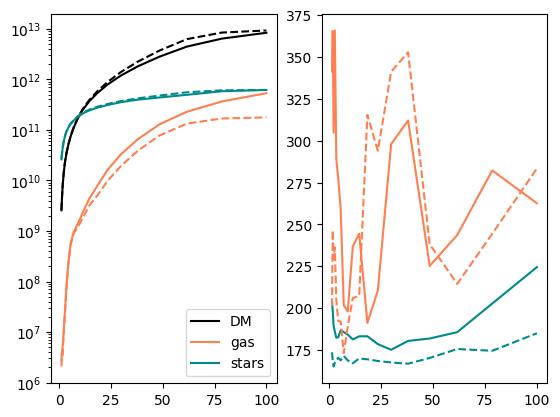

In [86]:
fig,ax = plt.subplots(1,2)

ax[0].plot(data['SubID_2/R_bins'][()], data['SubID_2/M_DM'][()], color = 'black', ls = 'solid', label = 'DM')
ax[0].plot(data['SubID_2/R_bins'][()], data['SubID_2/M_DM_sub'][()], color = 'black', ls = '--')
ax[0].plot(data['SubID_2/R_bins'][()], data['SubID_2/M_gas'][()], color = 'coral', ls = 'solid', label = 'gas')
ax[0].plot(data['SubID_2/R_bins'][()], data['SubID_2/M_gas_sub'][()], color = 'coral', ls = '--')
ax[0].plot(data['SubID_2/R_bins'][()], data['SubID_2/M_stars'][()], color = 'darkcyan', ls = 'solid', label = 'stars')
ax[0].plot(data['SubID_2/R_bins'][()], data['SubID_2/M_stars_sub'][()], color = 'darkcyan', ls = '--')
#plt.xscale('log')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(data['SubID_2/R_bins'][()][1:], data['SubID_2/V_rot_gas_AM'][()], color = 'coral', ls = 'solid')
ax[1].plot(data['SubID_2/R_bins'][()][1:], data['SubID_2/V_rot_stars_AM'][()], color = 'darkcyan', ls = 'solid')
ax[1].plot(data['SubID_2/R_bins'][()][1:], data['SubID_2/V_rot_gas_IT'][()], color = 'coral', ls = '--')
ax[1].plot(data['SubID_2/R_bins'][()][1:], data['SubID_2/V_rot_stars_IT'][()], color = 'darkcyan', ls = '--')